In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.cluster import KMeans
from collections import defaultdict
from scipy.spatial.distance import cdist
import statsmodels.api as sm
import jenkspy

This exploration divided by three parts:
1. explore continuous data to categorical data and see the difference
2. try different smoothing method and see how to decide which method works best
3. see how to process promotional data
4. see compare xgboost with lstm
5. see tree or random forest or xgboost visualization

In [2]:
# get raw data joined
# temp how to deal with it; promotional effects how to deal with it; see feature importance
data1 = pd.read_csv('./Features data set.csv')
data2 = pd.read_csv('./sales data-set.csv')
data3 = pd.read_csv('./stores data-set.csv')

In [ ]:
# general eda:
# timeseries plot for each store;
# each feature statistics, variance threshold; feature correlations; 
# for categorical data: level distribution(wehther biased)
# empty value, how to fill it? create new feature?

In [6]:
data1.head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,05/02/2010,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,12/02/2010,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,19/02/2010,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,26/02/2010,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,05/03/2010,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


In [7]:
data2.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,05/02/2010,24924.50,False
1,1,1,12/02/2010,46039.49,True
2,1,1,19/02/2010,41595.55,False
3,1,1,26/02/2010,19403.54,False
4,1,1,05/03/2010,21827.90,False


In [8]:
data3.head()

,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


In [ ]:
# combine tables
# data2 got department sales for each store
# Predict the department-wide sales for each store for the following year
# Model the effects of markdowns on holiday weeks
# Provide recommended actions based on the insights drawn, with prioritization placed on largest business impact

In [133]:
# take store 1 as example and take dept 1 as example
one = data1.loc[(data1.Store==1)]
two = data2.loc[(data2.Store==1) & (data2.Dept==1)]
three = data3.loc[(data3.Store==1)]
data = two.merge(one, on=['Store', 'Date', 'IsHoliday'], how='left').merge(three, on='Store', how='left')

In [134]:
data.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
0,1,1,05/02/2010,24924.50,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
1,1,1,12/02/2010,46039.49,True,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,A,151315
2,1,1,19/02/2010,41595.55,False,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,A,151315
3,1,1,26/02/2010,19403.54,False,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,A,151315
4,1,1,05/03/2010,21827.90,False,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,A,151315


In [136]:
# preprocessing
# fill nan
data.fillna(-99999, inplace=True) # denote missing value as -99999
# turn True and False to 0 or 1
data.loc[data.IsHoliday == True, 'IsHoliday'] = 1
data.loc[data.IsHoliday == False, 'IsHoliday'] = 0
data['promotion'] = 0
data.promotion.where(data.MarkDown1.notnull()==True,-1, inplace = True)
data.promotion.where(data.MarkDown2.notnull()==True,-1, inplace = True)
data.promotion.where(data.MarkDown3.notnull()==True,-1, inplace = True)
data.promotion.where(data.MarkDown4.notnull()==True,-1, inplace = True)
data.promotion.where(data.MarkDown5.notnull()==True,-1, inplace = True)
data.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size,promotion
0,1,1,05/02/2010,24924.50,0,42.31,2.572,-99999.0,-99999.0,-99999.0,-99999.0,-99999.0,211.096358,8.106,A,151315,0
1,1,1,12/02/2010,46039.49,1,38.51,2.548,-99999.0,-99999.0,-99999.0,-99999.0,-99999.0,211.242170,8.106,A,151315,0
2,1,1,19/02/2010,41595.55,0,39.93,2.514,-99999.0,-99999.0,-99999.0,-99999.0,-99999.0,211.289143,8.106,A,151315,0
3,1,1,26/02/2010,19403.54,0,46.63,2.561,-99999.0,-99999.0,-99999.0,-99999.0,-99999.0,211.319643,8.106,A,151315,0
4,1,1,05/03/2010,21827.90,0,46.50,2.625,-99999.0,-99999.0,-99999.0,-99999.0,-99999.0,211.350143,8.106,A,151315,0


First question: how to choose continuous versus categorical; eg., age, temperature

1. Think which model to use; eg., for tree, use either continuous or categorical, shouldn't have much difference; SVM use categorical data?

2. unique value of continuous data

3. see the continuous data relationship with y; if is linear related, then seperate bining shouldn't matter; but some continuous data cannot be seperate to brackets evenly according to y. (min variance within groups and max variance among groups)

4. In terms of how to encode categorical features:
    for ordinal attribute, just treat as numerical;
    if you use label for differnt variable, is the same in tree; 
    for SVM, NN, KNN, we use one-hot-encoding or dummy variable to encode the categorical features. Notice the dimensionality problem.

In [6]:
# Temperature as example: either split temp by bining or use it as continuous data
y_tmp = data[['Date', 'Weekly_Sales', 'Temperature', 'promotion']]

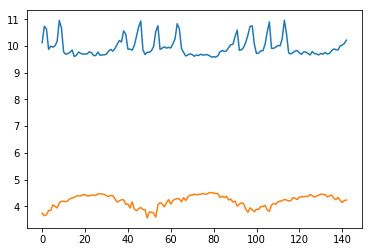

In [118]:
plt.plot(np.log(y_tmp.Weekly_Sales))
plt.plot(np.log(y_tmp.Temperature))

In [126]:
slope, intercept, r_value, p_value, std_err = stats.linregress(y_tmp.Temperature, y_tmp.Weekly_Sales.values)
print("slope: %f" % slope)
print("p-value: %f" % p_value)
print("R-squared: %f" % r_value**2)


slope: -327.678679
p-value: 0.000000
R-squared: 0.224543


(array([ 4., 10., 12., 10., 13., 20., 15., 19., 28., 12.]),
 array([35.4  , 41.025, 46.65 , 52.275, 57.9  , 63.525, 69.15 , 74.775,
        80.4  , 86.025, 91.65 ]),
 <a list of 10 Patch objects>)

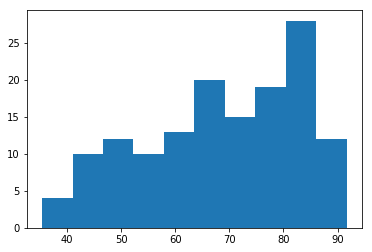

In [138]:
plt.hist(y_tmp.Temperature)

In [9]:
# build dictionary of sale and temperature
dicts = {}
for row in y_tmp.iterrows():
    dicts[row[1].Weekly_Sales] = row[1].Temperature

In [17]:
# use k-means for one-cluster : maximize variance among groups, minimize  variance within groups
breaks = jenkspy.jenks_breaks(list(dicts.keys()), nb_class=9)

In [31]:
tmp_breaks = []
for i in range(len(breaks)-1):
    start = breaks[i]
    end = breaks[i+1]
    tmps = [dicts[key] for key in dicts.keys() if key<=end and key>= start]
    tmp_breaks += [[min(tmps), max(tmps)]]

turns out the breaks are not that clear, so we will just use the temperature as continuous data

In [32]:
tmp_breaks

[[48.27, 91.65],
 [35.4, 87.16],
 [46.63, 82.11],
 [42.27, 71.74],
 [42.31, 71.27],
 [43.93, 69.07],
 [36.39, 72.03],
 [38.51, 72.99],
 [45.32, 72.99]]

Second Question: 
Try different Smoothing Methods: Loess Smoothing / Moving Average Smoothing / IQR Smoothing / Sigma smoothing (if larger than or smaller than mean +/- 3 std


Measure by: A(s)S(moothing)A(s)P(ossible) : neghborhood points variance compare with previous variance, kurtosis compare with previous kurtosis

In [71]:
# try different smoothing methods
def asap_measurement(y):
    # neighbor variance
    neighbors = []
    for i in range(len(y)-1):
        neighbors += [abs(y[i]-y[i+1])]
    return np.std(neighbors), stats.kurtosis(y)

In [120]:
# lowess smoothing 

def lowess(y, frac=[1/3], it=[0]):
    plt.plot(y)
    plt.title('original weekly sales')
    plt.show()
    print(np.std(y), stats.kurtosis(y))
#     if len(frac) > 1 or len(it) > 1:
    for f in frac:
        for i in it:
            lowess = sm.nonparametric.lowess
            smooth_output = lowess(y, range(len(y)), f, i, return_sorted=False)
            plt.plot(smooth_output)
            plt.title('smoothed weekly sales fraction is: ' + str(f) + 'iteration round is: ' + str(i))
            plt.show()
            # Measure smoothness, compare std and kurtosis with original one
            print(asap_measurement(smooth_output))

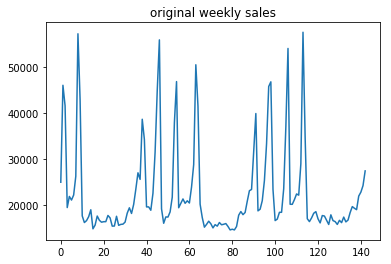

9819.832817554201 3.202757510372523


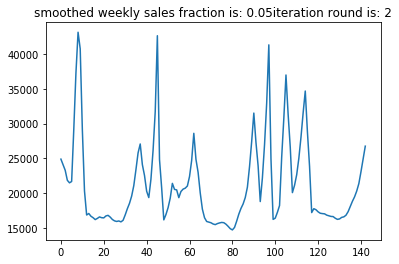

(3010.450186449285, 2.3664720507265775)


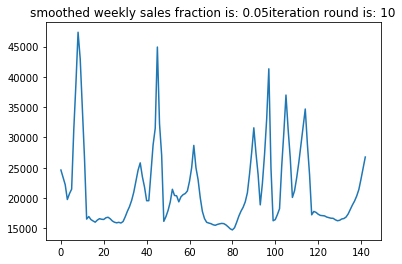

(3045.3949248695462, 2.7038439069503575)


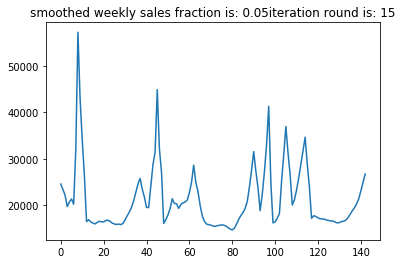

(3704.476562495004, 6.058927935031322)


In [121]:
lowess(data.Weekly_Sales, frac=[0.05], it=[10])

In [139]:
lowess = sm.nonparametric.lowess
data['y'] = lowess(data.Weekly_Sales, range(len(data.Weekly_Sales)), 0.05, 10, return_sorted=False)

In [ ]:
# use larger dataset to train the model: use most recent data as test data, and filter data according to their id
# general grouping information: 
# store: number of dept; sum of sale per month, per week
# for each store, deptarment sale difference

In [317]:
data.Date = pd.to_datetime(data.Date, format='%d/%m/%Y')
data['Month'] = data.Date.dt.month
data['Year'] = data.Date.dt.year
data['day'] = data.Date.dt.day
data['dayofweek'] = data.Date.dt.dayofweek

In [318]:
data.tail()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,...,MarkDown5,CPI,Unemployment,Type,Size,promotion,Month,Year,day,dayofweek
421565,45,98,2012-09-28,508.37,0,64.88,3.997,4556.61,20.64,1.50,...,3288.25,192.013558,8.684,B,118221,0,9,2012,28,4
421566,45,98,2012-10-05,628.10,0,64.89,3.985,5046.74,-99999.00,18.82,...,2340.01,192.170412,8.667,B,118221,0,10,2012,5,4
421567,45,98,2012-10-12,1061.02,0,54.47,4.000,1956.28,-99999.00,7.89,...,3990.54,192.327265,8.667,B,118221,0,10,2012,12,4
421568,45,98,2012-10-19,760.01,0,56.47,3.969,2004.02,-99999.00,3.18,...,1537.49,192.330854,8.667,B,118221,0,10,2012,19,4
421569,45,98,2012-10-26,1076.80,0,58.85,3.882,4018.91,58.08,100.00,...,858.33,192.308899,8.667,B,118221,0,10,2012,26,4


In [303]:
filter_data = data.loc[(data.Year == 2012) & (data.Month==10) & (data.Store.isin([33,20]))]

In [305]:
filter_data['id'] = filter_data['Store'].map(str) + '_' + filter_data['Dept'].map(str)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [313]:
keys = filter_data.id.unique()

In [319]:
data['id'] = data['Store'].map(str) + '_' + data['Dept'].map(str)
new_data = data.loc[data.id.isin(keys)]

In [321]:
len(data)

421570

In [323]:
lowess = sm.nonparametric.lowess
new_data['y'] = lowess(new_data.Weekly_Sales, range(len(new_data.Weekly_Sales)), 0.05, 10, return_sorted=False)
new_data.head()
new_data.to_csv('./new_data.csv', encoding='utf-8', index=False)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [324]:
new_data

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,...,Unemployment,Type,Size,promotion,Month,Year,day,dayofweek,id,y
187335,20,1,2010-02-05,46021.21,0,25.92,2.784,-99999.00,-99999.00,-99999.00,...,8.187,A,203742,0,2,2010,5,4,20_1,29867.776461
187336,20,1,2010-02-12,52734.17,1,22.12,2.773,-99999.00,-99999.00,-99999.00,...,8.187,A,203742,0,2,2010,12,4,20_1,29902.872017
187337,20,1,2010-02-19,55649.79,0,25.43,2.745,-99999.00,-99999.00,-99999.00,...,8.187,A,203742,0,2,2010,19,4,20_1,29937.966806
187338,20,1,2010-02-26,36805.42,0,32.32,2.754,-99999.00,-99999.00,-99999.00,...,8.187,A,203742,0,2,2010,26,4,20_1,29973.060795
187339,20,1,2010-03-05,41206.78,0,31.75,2.777,-99999.00,-99999.00,-99999.00,...,8.187,A,203742,0,3,2010,5,4,20_1,30008.153949
187340,20,1,2010-03-12,47291.77,0,43.82,2.818,-99999.00,-99999.00,-99999.00,...,8.187,A,203742,0,3,2010,12,4,20_1,30043.246229
187341,20,1,2010-03-19,52993.00,0,47.32,2.844,-99999.00,-99999.00,-99999.00,...,8.187,A,203742,0,3,2010,19,4,20_1,30078.337591
187342,20,1,2010-03-26,61598.76,0,50.49,2.854,-99999.00,-99999.00,-99999.00,...,8.187,A,203742,0,3,2010,26,4,20_1,30113.427986
187343,20,1,2010-04-02,149743.97,0,51.00,2.850,-99999.00,-99999.00,-99999.00,...,7.856,A,203742,0,4,2010,2,4,20_1,30148.517367
187344,20,1,2010-04-09,72907.28,0,65.10,2.869,-99999.00,-99999.00,-99999.00,...,7.856,A,203742,0,4,2010,9,4,20_1,30183.605685


In [295]:
# each store roughly have 70 stores
data.Dept.groupby(data.Store).unique().reset_index()

,Store,Dept
0,1,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14..."
1,2,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14..."
2,3,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14..."
3,4,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14..."
4,5,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14..."
5,6,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14..."
6,7,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14..."
7,8,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14..."
8,9,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14..."
9,10,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14..."


In [261]:
# 33 min, 20 max
sale_stores = data.Weekly_Sales.groupby(data.Store).sum().reset_index()
sale_stores.sort_values(by = 'Weekly_Sales')

,Store,Weekly_Sales
32,33,3.716022e+07
43,44,4.329309e+07
4,5,4.547569e+07
35,36,5.341221e+07
37,38,5.515963e+07
2,3,5.758674e+07
29,30,6.271689e+07
36,37,7.420274e+07
15,16,7.425243e+07
28,29,7.714155e+07


In [267]:
store_data.Store.unique()

array([20, 33])

In [265]:
store_data = data.loc[data.Store.isin([33,20])]
sale_dept = store_data.Weekly_Sales.groupby([store_data.Store, store_data.Dept]).sum().reset_index()
sale_dept.sort_values(by = 'Weekly_Sales')

,Store,Dept,Weekly_Sales
43,20,47,-378.58
140,33,99,0.11
102,33,27,1.00
122,33,71,5.00
106,33,34,21.76
60,20,78,29.00
115,33,49,40.00
123,33,72,62.72
113,33,44,71.51
107,33,35,95.00


In [268]:
store_data.loc[(store_data.Store==33) & (store_data.Dept == 34)]

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size,promotion
316980,33,34,29/04/2011,8.00,0,77.44,4.151,-99999.0,-99999.0,-99999.0,-99999.0,-99999.0,128.999867,8.687,A,39690,0
316981,33,34,20/05/2011,3.88,0,76.07,3.990,-99999.0,-99999.0,-99999.0,-99999.0,-99999.0,129.075677,8.687,A,39690,0
316982,33,34,22/07/2011,3.88,0,97.17,3.697,-99999.0,-99999.0,-99999.0,-99999.0,-99999.0,129.150774,8.442,A,39690,0
316983,33,34,16/09/2011,3.00,0,85.79,3.784,-99999.0,-99999.0,-99999.0,-99999.0,-99999.0,129.430600,8.442,A,39690,0
316984,33,34,07/10/2011,3.00,0,81.16,3.827,-99999.0,-99999.0,-99999.0,-99999.0,-99999.0,129.693800,8.010,A,39690,0


In [299]:
same_dept_dif_stores = data.loc[(data.Dept == 1)]

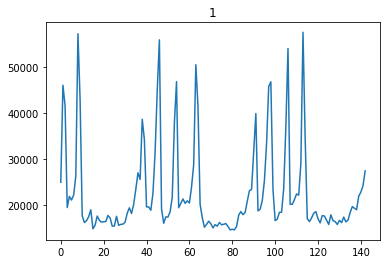

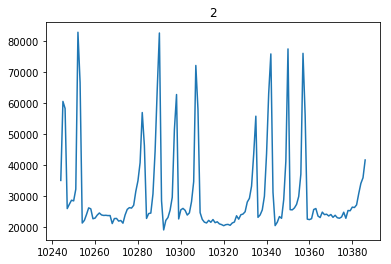

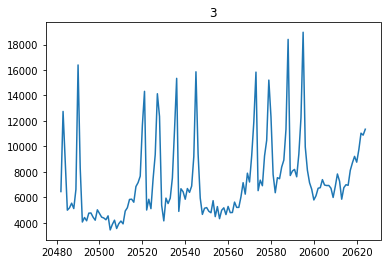

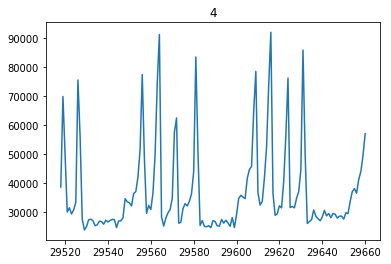

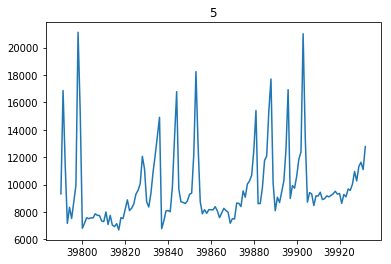

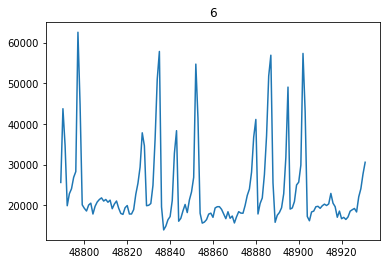

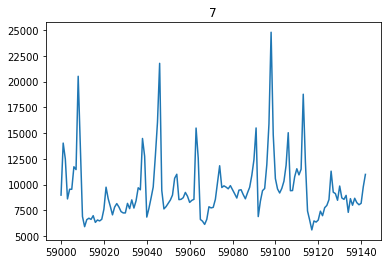

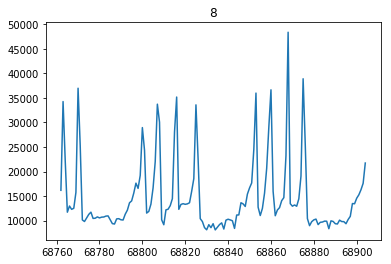

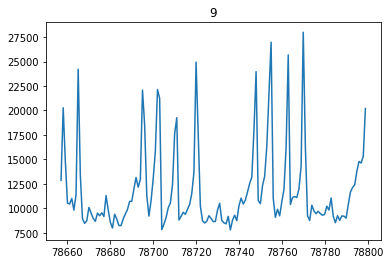

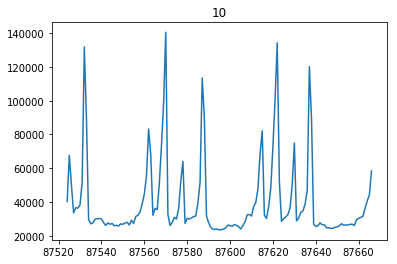

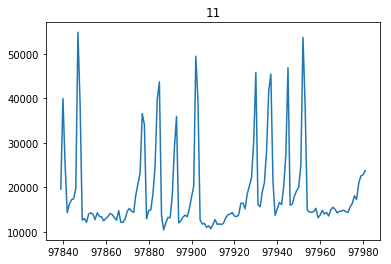

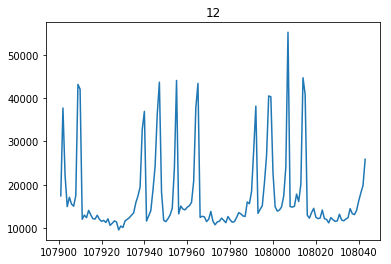

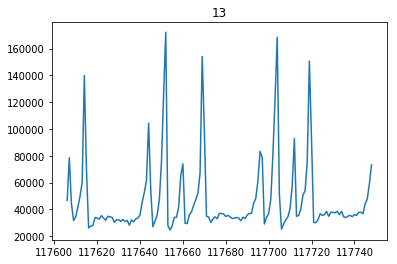

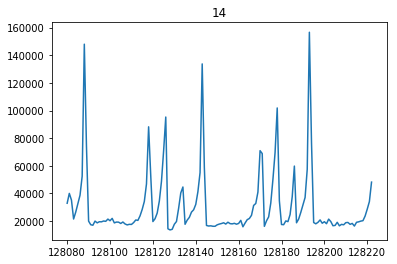

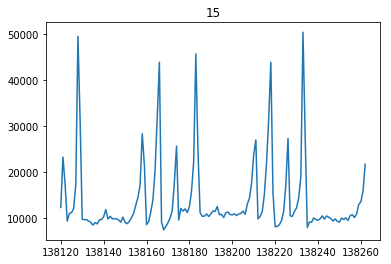

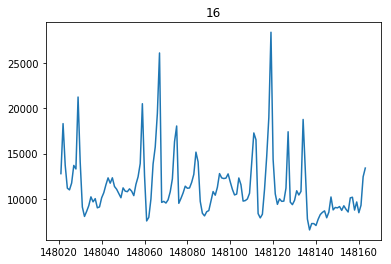

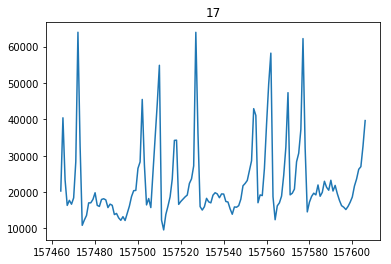

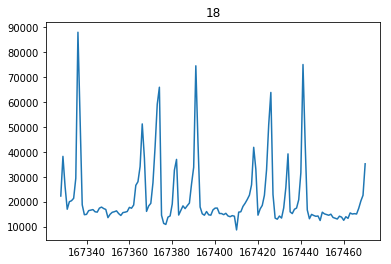

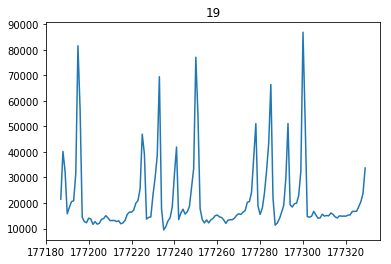

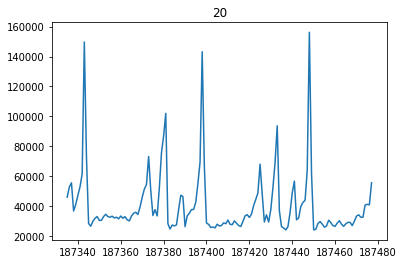

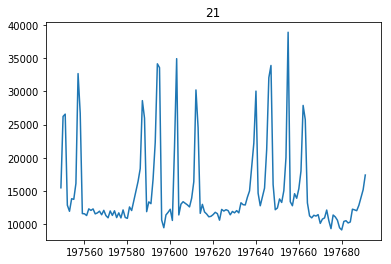

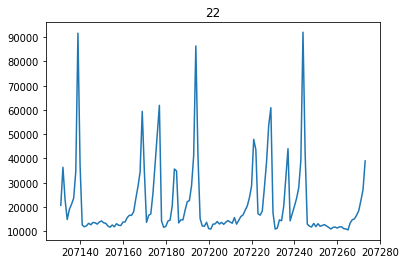

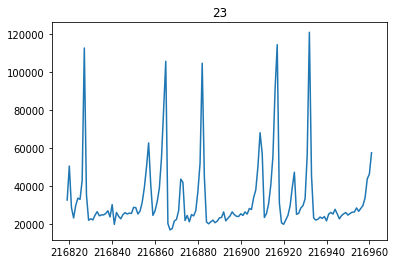

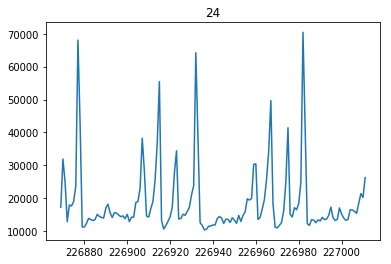

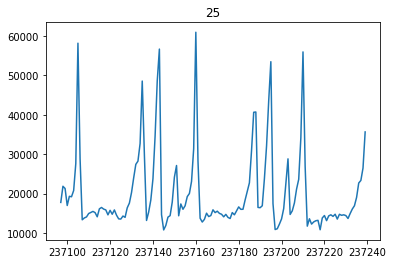

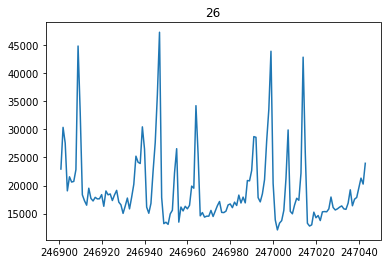

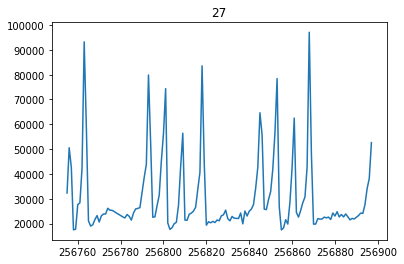

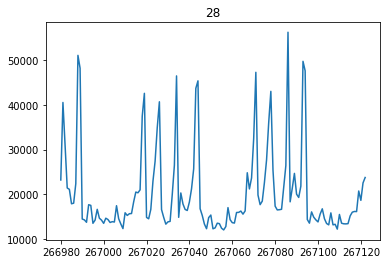

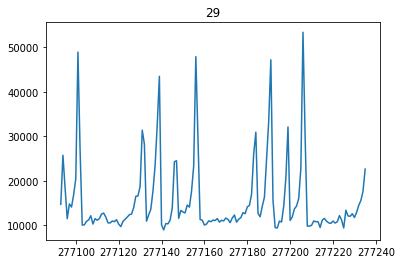

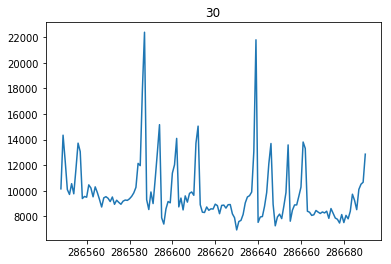

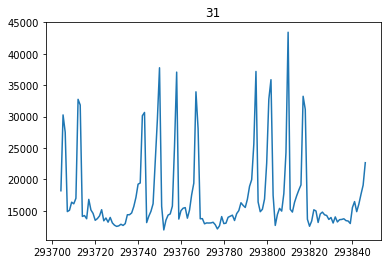

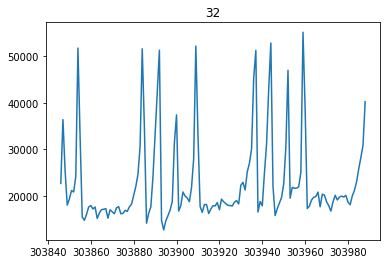

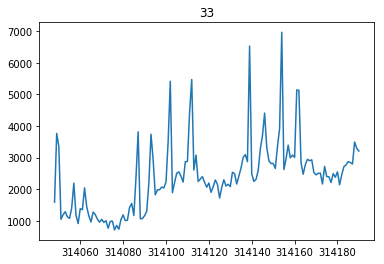

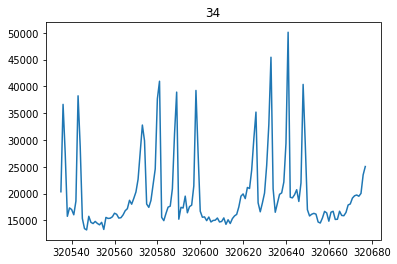

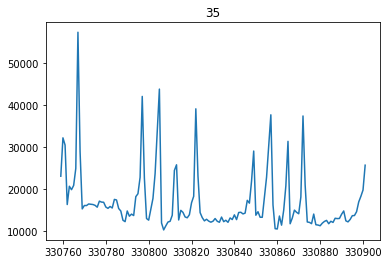

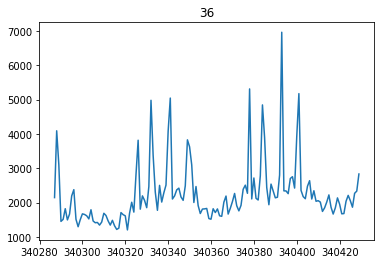

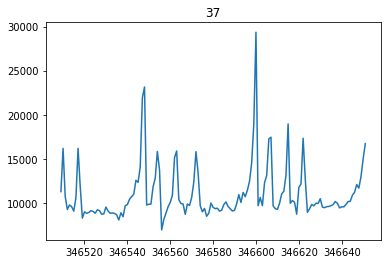

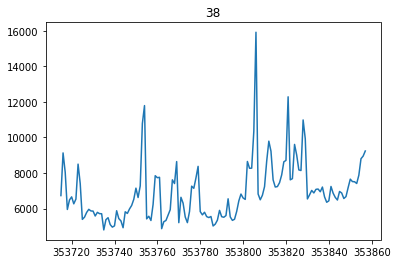

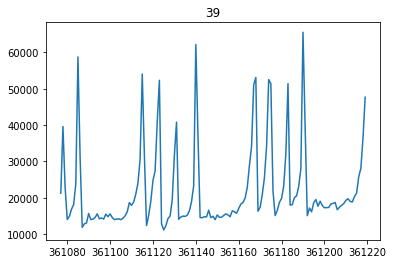

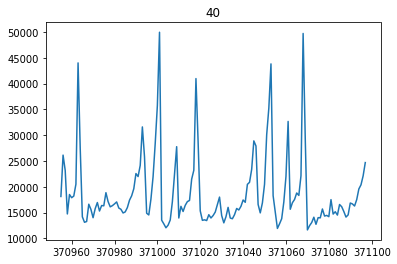

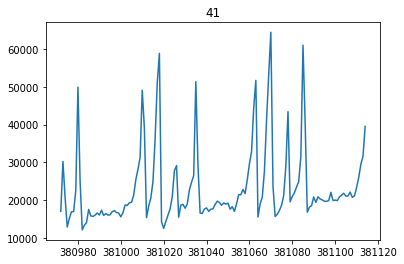

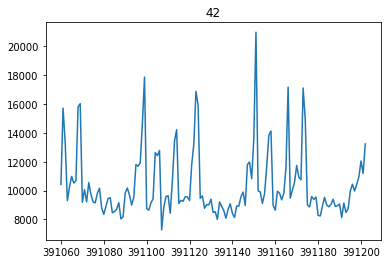

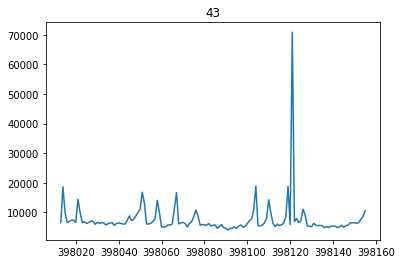

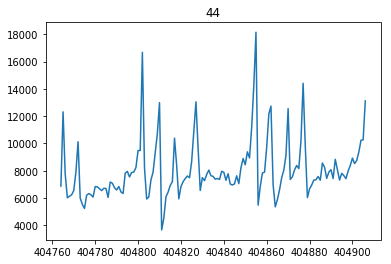

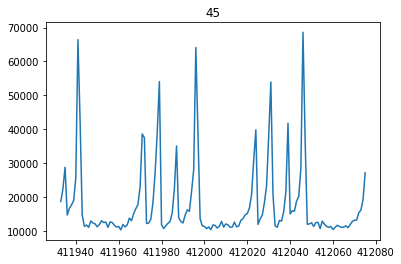

In [300]:
# plot differnt store weeky sale per week of the same dept
# measure timeseries similarities to see how different model is used for same timeseries features
# check out later: https://datascience.stackexchange.com/questions/29283/how-to-find-similar-time-series
for store in same_dept_dif_stores.Store.unique():
    y_series = same_dept_dif_stores.loc[same_dept_dif_stores.Store == store].Weekly_Sales
    plt.plot(y_series)
    plt.title(str(store))
    plt.show()

In [233]:
# save preprocess data
def save_process_data():
    data = data2.merge(data1, on=['Store', 'Date', 'IsHoliday'], how='left').merge(data3, on='Store', how='left')
    # process missing values
    data.fillna(-99999, inplace=True) # denote missing value as -99999
    # turn True and False to 0 or 1
    data.loc[data.IsHoliday == True, 'IsHoliday'] = 1
    data.loc[data.IsHoliday == False, 'IsHoliday'] = 0
    # add new features
    data['promotion'] = 0
    data.promotion.where(data.MarkDown1.notnull()==True,-1, inplace = True)
    data.promotion.where(data.MarkDown2.notnull()==True,-1, inplace = True)
    data.promotion.where(data.MarkDown3.notnull()==True,-1, inplace = True)
    data.promotion.where(data.MarkDown4.notnull()==True,-1, inplace = True)
    data.promotion.where(data.MarkDown5.notnull()==True,-1, inplace = True)
    # smoothing
    lowess = sm.nonparametric.lowess
    data['y'] = lowess(data.Weekly_Sales, range(len(data.Weekly_Sales)), 0.05, 10, return_sorted=False)
    data.head()
    data.to_csv('./all_data.csv', encoding='utf-8', index=False)

Question 3: compare XGBoost with LSTM

In [ ]:
# create possible features for example data
# min, max, avg, std, skew, kurtosis of the training peroid
# -7, -14, -21 days before current test date's sales, promotion, holiday, markdown, fuel... all features in example data
# except search them 7 days before

# compare this feature engineering part with LSTM and model promotion as ensemble methods

In [140]:
example_data = data[['Weekly_Sales', 'IsHoliday', 'Temperature',
       'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4',
       'MarkDown5', 'CPI', 'Unemployment', 'promotion',
       'y']]

In [141]:
example_data.iloc[:-6]

,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,promotion,y
0,24924.50,0,42.31,2.572,-99999.00,-99999.00,-99999.00,-99999.00,-99999.00,211.096358,8.106,0,24611.103103
1,46039.49,1,38.51,2.548,-99999.00,-99999.00,-99999.00,-99999.00,-99999.00,211.242170,8.106,0,23372.055376
2,41595.55,0,39.93,2.514,-99999.00,-99999.00,-99999.00,-99999.00,-99999.00,211.289143,8.106,0,22198.986226
3,19403.54,0,46.63,2.561,-99999.00,-99999.00,-99999.00,-99999.00,-99999.00,211.319643,8.106,0,19748.284020
4,21827.90,0,46.50,2.625,-99999.00,-99999.00,-99999.00,-99999.00,-99999.00,211.350143,8.106,0,20719.299400
5,21043.39,0,57.79,2.667,-99999.00,-99999.00,-99999.00,-99999.00,-99999.00,211.380643,8.106,0,21460.387984
6,22136.64,0,54.58,2.720,-99999.00,-99999.00,-99999.00,-99999.00,-99999.00,211.215635,8.106,0,31277.471296
7,26229.21,0,51.45,2.732,-99999.00,-99999.00,-99999.00,-99999.00,-99999.00,211.018042,8.106,0,38852.500744
8,57258.43,0,62.27,2.719,-99999.00,-99999.00,-99999.00,-99999.00,-99999.00,210.820450,7.808,0,47354.150399
9,42960.91,0,65.86,2.770,-99999.00,-99999.00,-99999.00,-99999.00,-99999.00,210.622857,7.808,0,42960.910000


In [122]:
def generate_features(df, forward_days = [7,14,21]):
    columns = df.columns
    feature_set = []
    new_column_names = []
    for p in forward_days:
        for feature in columns:
            if p <= len(df):
                feature_set += [df.iloc[-p][feature]]
            else:
                feature_set += [-99999] # mark as nan
            new_column_names += [str(-p) + '_' + str(feature)]
    return feature_set, new_column_names

In [174]:
# when training and testing using mse or others?? , test which slide gap and history time make more sense?
def generate_backtest_data(df, predict_future_days, peroid, step, forward_days):
    '''
    y is array of training data, include first prediction day [t_n, t_{n-1}... t1] (t1, t2, .. t7): prediction day for eg., 
    predict future days means how many future days to predict using machine learning models 
    '''
    # features for backtest data (train, validation)
    X_train = [[] for _ in range(predict_future_days)]
    X_validation = [[] for _ in range(predict_future_days)]
    Y_train = [[] for _ in range(predict_future_days)]
    Y_validation = [[] for _ in range(predict_future_days)]

    # each train data is 'peroid' days ahead of test data
    c = 0 # count backtest times
    prediction_day_index = [-i for i in range(predict_future_days)]
    last_test_day_index = [i-predict_future_days for i in prediction_day_index]
    for i in range(predict_future_days): # Generate train data for each day model
        t = last_test_day_index[c] # start from last test day, then last train day is last test day - 1    
        while -(t - peroid) <= len(df):
            
            test = df.iloc[t-peroid-1 : t+1]
            train = df.iloc[t-peroid: t] # train data not included test data
            
            other_feature_cols = ['IsHoliday', 'Temperature','Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4','MarkDown5', 'CPI', 'Unemployment', 'promotion', 'y']
            # X_train
            Xtrain_y_features = [np.min(train.y), np.max(train.y), np.mean(train.y), np.std(train.y), stats.skew(train.y), stats.kurtosis(train.y)]

            y_names = ['min_y', 'max_y', 'mean_y', 'std_y', 'skew_y', 'kurtosis_y']
            Xtrain_other_features, other_names = generate_features(train[other_feature_cols])
            # Xtest
            Xtest_y_features = [np.min(test.y), np.max(test.y), np.mean(test.y), np.std(test.y), stats.skew(test.y), stats.kurtosis(test.y)]

            Xtest_other_features, _ = generate_features(test[other_feature_cols])
            # Ytrain
            Y_train[c] += [df.iloc[t-1].y]
            # Ytest
            Y_validation[c] += [df.iloc[t].y]
            
            X_train[c] += [Xtrain_y_features + Xtrain_other_features]
            X_validation[c] += [Xtest_y_features + Xtest_other_features]
            
            feature_names = y_names + other_names  
            t -= step 
        c += 1
    return np.array(X_train), np.array(X_validation), np.array(Y_train), np.array(Y_validation), feature_names

In [175]:
X_train, X_validation, Y_train, Y_validation, feature_names = generate_backtest_data(example_data, 2, 60, 7, [7,14,21])

In [177]:
X_train.shape

(2, 12, 42)

In [166]:
def generate_test_data(df, predict_future_days, peroid, step, forward_days, generate_way):

    prediction_day_index = [-i for i in range(predict_future_days)]
    last_test_day_index = [i-predict_future_days for i in prediction_day_index]
    c = 0
    if generate_way == 0: # use last day as feature, thus all future days have same features but different models
        X_test = []
        t = prediction_day_index[c] - 1   

        train = df.iloc[t-peroid: t] # train data not included test data

        other_feature_cols = ['IsHoliday', 'Temperature','Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4','MarkDown5', 'CPI', 'Unemployment', 'promotion', 'y']

        X_test = [np.min(train.y), np.max(train.y), np.mean(train.y), np.std(train.y), stats.skew(train.y), stats.kurtosis(train.y)]
        Xtrain_other_features, _ = generate_features(train[other_feature_cols])
        X_test += Xtrain_other_features

        
    else:
        X_test = [[] for _ in range(predict_future_days)]
        Y_test = []
        for i in range(predict_future_days): # Generate train data for each day model
            t = last_test_day_index[c]
            train = df.iloc[t-peroid: t] # train data not included test data
            other_feature_cols = ['IsHoliday', 'Temperature','Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4','MarkDown5', 'CPI', 'Unemployment', 'promotion', 'y']

            X_test[c] = [np.min(train.y), np.max(train.y), np.mean(train.y), np.std(train.y), stats.skew(train.y), stats.kurtosis(train.y)]
            Xtrain_other_features, _ = generate_features(train[other_feature_cols])
            X_test[c] += Xtrain_other_features

            c+=1

    Y_test = df.iloc[-predict_future_days:].y.values
    
    return np.array(X_test), Y_test
            

In [171]:
X_test, Y_test = generate_test_data(example_data, 2, 60, 7, [7,14,21], 1)

In [208]:
X_train[i].shape

(12, 42)

In [211]:
X_test[i].reshape(1,-1).shape

(1, 42)

In [181]:
import xgboost as xgb

In [179]:
X_train.shape[0]

2

In [183]:
X_validation.shape

(2, 12, 42)

In [221]:
def rmse(y, yhat):
    return np.sqrt(((y - yhat)**2).mean())

def mape(pred, actual):
    return np.mean(abs((actual - pred) / actual))

def Mean_Absolute_Scaled_Error(): # compare with naive random walk
    

In [228]:
param = {'max_depth': 10, 'eta': 1, 'silent': 1,"objective":"reg:linear"}
param['nthread'] = 4
param['eval_metric'] = 'rmse'
num_round = 10

for i in range(X_train.shape[0]):
    dtrain = xgb.DMatrix(np.array(X_train[i]), label=np.array(Y_train[i]))
    bst = xgb.train(param, dtrain, num_round)
    dvalidation = xgb.DMatrix(np.array(X_validation[i]))
    validation_pred = bst.predict(dvalidation)
    print('cross validation mape ..' + str(mape(validation_pred, Y_validation[i])))
    print('cross validation rmse ..' + str(rmse(validation_pred, Y_validation[i])))
    dtest = xgb.DMatrix(X_test[i].reshape(1,-1))
    ypred = bst.predict(dtest)
    print(ypred)
    print('final test mape ..' + str(mape(ypred, Y_test[i])))
    print('final test rmse ..' + str(rmse(ypred, Y_test[i])))

cross validation mape ..0.1343234500095328
cross validation rmse ..4645.494406283456
[23111.105]
final test mape ..0.07278776
final test rmse ..1814.2617
cross validation mape ..0.15464132270238037
cross validation rmse ..6606.117058451914
[21400.76]
final test mape ..0.20030774
final test rmse ..5360.4844


In [226]:
ypred

array([21398.613], dtype=float32)

In [223]:
Y_test

array([24925.36701525, 26761.24479941])

In [224]:
example_data[-4:]

,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,promotion,y
139,21904.47,0,68.55,3.617,8077.89,-99999.00,18.22,3617.43,3626.14,223.181477,6.573,0,21400.594413
140,22764.01,0,62.99,3.601,2086.18,-99999.00,8.11,602.36,5926.45,223.381296,6.573,0,23111.006380
141,24185.27,0,67.97,3.594,950.33,-99999.00,4.93,80.25,2312.85,223.425723,6.573,0,24925.367015
142,27390.81,0,69.16,3.506,2585.85,31.75,6.00,1057.16,1305.01,223.444251,6.573,0,26761.244799


In [217]:
Y_test[i]

26761.24479941234

In [206]:
mape(Y_validation[0], validation_pred)

0.12141660402347591

In [200]:
validation_pred

array([28608.459, 18041.375, 16976.816, 17128.37 , 23820.557, 30135.898,
       25362.152, 27204.385, 17211.754, 15553.508, 15778.22 , 20791.016],
      dtype=float32)

In [202]:
Y_validation[0]

array([24925.36701525, 17357.62400015, 16642.49325338, 17329.68612896,
       31818.535     , 31363.33666667, 16240.98      , 23844.41565071,
       18459.84114262, 15249.19582528, 15582.44126807, 23009.31875813])

In [192]:
Y_train[i].reshape(-1,1).shape

(12, 1)

In [188]:
# use Partial dependence plots to see how each feature works

In [43]:
example_data.iloc[:-2]

,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,promotion,y
0,24924.50,0,42.31,2.572,0.00,0.00,0.00,0.00,0.00,211.096358,8.106,0,24611.103103
1,46039.49,1,38.51,2.548,0.00,0.00,0.00,0.00,0.00,211.242170,8.106,0,23372.055376
2,41595.55,0,39.93,2.514,0.00,0.00,0.00,0.00,0.00,211.289143,8.106,0,22198.986226
3,19403.54,0,46.63,2.561,0.00,0.00,0.00,0.00,0.00,211.319643,8.106,0,19748.284020
4,21827.90,0,46.50,2.625,0.00,0.00,0.00,0.00,0.00,211.350143,8.106,0,20719.299400
5,21043.39,0,57.79,2.667,0.00,0.00,0.00,0.00,0.00,211.380643,8.106,0,21460.387984
6,22136.64,0,54.58,2.720,0.00,0.00,0.00,0.00,0.00,211.215635,8.106,0,31277.471296
7,26229.21,0,51.45,2.732,0.00,0.00,0.00,0.00,0.00,211.018042,8.106,0,38852.500744
8,57258.43,0,62.27,2.719,0.00,0.00,0.00,0.00,0.00,210.820450,7.808,0,47354.150399
9,42960.91,0,65.86,2.770,0.00,0.00,0.00,0.00,0.00,210.622857,7.808,0,42960.910000
